In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nf-ton-iotv1/NetFlow_v1_Features.csv
/kaggle/input/nf-ton-iotv1/NF-ToN-IoT.csv


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, adjusted_rand_score, silhouette_score
from sklearn.decomposition import PCA

In [3]:
data_path = "/kaggle/input/nf-ton-iotv1/NF-ToN-IoT.csv"
df = pd.read_csv(data_path, low_memory=False)
print(f"Dataset shape: {df.shape}")

Dataset shape: (1379274, 14)


In [4]:
label_col = 'Label'

X = df.drop(columns=[label_col])
y = df[label_col].values

print(f"Feature matrix shape: {X.shape}")
print(f"Label distribution:\n{pd.Series(y).value_counts()}")

Feature matrix shape: (1379274, 13)
Label distribution:
1    1108995
0     270279
Name: count, dtype: int64


In [5]:
# Drop IP columns before encoding
X = X.drop(columns=['IPV4_SRC_ADDR', 'IPV4_DST_ADDR'])  # replace with actual IP column names if different

categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
X_encoded = pd.get_dummies(X, columns=categorical_cols)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)


In [6]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [7]:
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

n_comp = min(20, X_scaled.shape[0], X_scaled.shape[1])
pca = PCA(n_components=n_comp, random_state=42)
X_pca = pca.fit_transform(X_scaled)

k = 2
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_pca)

def evaluate_clustering_fast(y_true, cluster_labels, X_data):
    contingency = confusion_matrix(y_true, cluster_labels)
    purity = np.sum(np.max(contingency, axis=0)) / np.sum(contingency)
    ari = adjusted_rand_score(y_true, cluster_labels)
    print(f"Adjusted Rand Index (ARI): {ari:.4f}")
    print(f"Purity Score: {purity:.4f}")
    
    sample_size = min(5000, len(X_data))
    sample_idx = np.random.choice(len(X_data), sample_size, replace=False)
    sil_score = silhouette_score(X_data[sample_idx], cluster_labels[sample_idx])
    print(f"Silhouette Score (sampled {sample_size}): {sil_score:.4f}")

evaluate_clustering_fast(y_encoded, cluster_labels, X_pca)


Adjusted Rand Index (ARI): 0.9320
Purity Score: 0.9853
Silhouette Score (sampled 5000): 0.3734


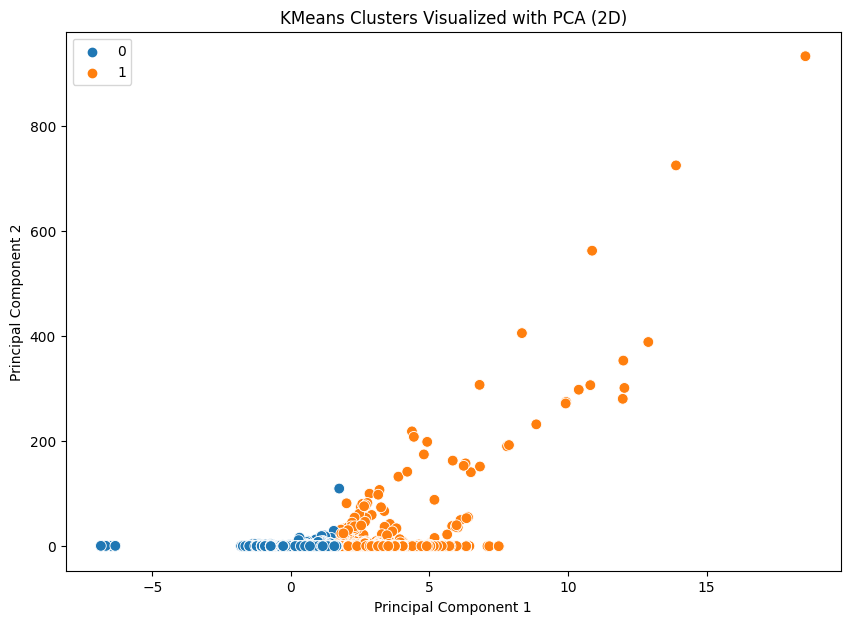

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

pca_2d = PCA(n_components=2, random_state=42)
X_vis = pca_2d.fit_transform(X_scaled)

plt.figure(figsize=(10, 7))
sns.scatterplot(x=X_vis[:, 0], y=X_vis[:, 1], hue=cluster_labels, palette='tab10', legend='full', s=60)
plt.title('KMeans Clusters Visualized with PCA (2D)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()